## Deep Neural Networks

In our [last notebook](../03_ArtificialNeurons/Supplement_MultivariateActivationFunctions.ipynb), we learned how multiple inputs to a single activation function can influence the activation function value. Given a particular set of inputs, we interpreted the function's output to be the degree of confidence in a positive or negative decision; for instance, a output of `0.80` corresponds to an 80% confidence that a positive decision is the correct one for the provided data (and conversely, a 20% confidence that a negative decision is the correct one).

In this notebook, we create a new mathematical model by composing these activation functions into a network of activation functions wherein the output of several activation functions serves as weighted input into another activation function. Such models are known as _neural networks_, and are extraordinarily well-equipped to learn an extremely wide variety of classification and decision functions.

### Software Prerequisites

The following Python libraries are prerequisites to run this notebook; simply run the following code block to install them. They are also listed in the `requirements.txt` file in the root of this notebook's [GitHub repository](https://github.com/uccs-math-clinic/mc-workshops).

In [1]:
%pip install matplotlib==3.5.1 \
             numpy==1.21.5 \
             torch==1.11.0

You should consider upgrading via the '/work/jonathan/uccs/mc-workshops/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


The Python kernel must be restarted after running the above code block for the first time within a particular virtual environment. This may be accomplished by navigating to `Kernel -> Restart` in the menu bar.

With our package dependencies installed, we can run the following [boilerplate code](https://en.wikipedia.org/wiki/Boilerplate_code) in order to import the packages needed for this notebook:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

%matplotlib notebook
plt.ion()

## Introducing our Model

Earlier, we claimed that neural networks are well-suited to learn a wide variety of classification and decision functions. Theoretically, neural networks act as [universal function approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem); that is, given sufficient training data and neurons within the middle (hidden) layers, neural networks are capable of approximating arbitrary continuous functions defined on compact subsets of $\mathbb{R}^n$.

In practice, there exist pragmatic computational constraints upon the structure and size of neural networks which are feasible to work with. A neural network's efficacy in classification and training efficiency depend highly on both the quality of training data (i.e., how well the data actually represents the phenomenon we wish to model) and the structure of the underlying neural network. Oftentimes, it is only the latter of these over which we have any control; in fact, choosing an appropriate neural network structure for a particular data set often comprises much of the work behind learning a useful data model.

Recall that neural networks consist of weighted compositions of activation functions. In particular, a set of activation functions (or neurons) whose output serves as weighted input into another activation function is said to comprise a _layer_ of the neural network. In this notebook, we use the now-familiar logistic function as our activation function of choice, though of course [many](https://en.wikipedia.org/wiki/ReLU) [others](https://en.wikipedia.org/wiki/Gaussian_function) [exist](https://en.wikipedia.org/wiki/Heaviside_step_function).

### Notation
Suppose that we wish to calculate the input value for the second layer of a neural network which takes three distinct values (or input neurons) as input. Each of these input values has associated with it a weight which is unique with respect to the destination neuron. We observed in the previous notebook that keeping track of even two inputs along with their correspondings weights, biases, and gradient quickly became tiresome. As we consider networks which may contain hundreds or even millions of neurons in a single layer, it becomes apparent that we must stretch our intuition somewhat to adopt a new notation which we can use to model complex data sets with many interconnected layers. We achieve this by way of matrix computation. For example, we calculate all input terms for each of the two neurons in the second layer simultaneously via the following matrix calculation:

$$
\begin{bmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23}
\end{bmatrix} \cdot
\begin{bmatrix}
x_{1} \\
x_{2} \\
x_{3}
\end{bmatrix}
+
\begin{bmatrix}
b_{11} \\
b_{21}
\end{bmatrix}
$$

If we break this down, we see that the result is a $2 \times 1$ column matrix whose entries correspond to the input values for each of the two neurons in the second layer. The model inputs (the vector $\textbf{x}$) are a $3 \times 1$ column vector wherein each entry corresponds to the activation function value for each of the three _input_ neurons. Moreover, we see that the weight matrix contains a single unique value for each activation function value and input value pair; the element $w_23$ represents the weight applied to the _third_ neuron which serves as an input component for the _second_ neuron of the next layer - that is, the subscript indices are to be read _backward_ when interpreting what role a particular weight plays in the network. If one were to encounter the notation for a particular weight element prior to learning the matrix representation for these calculations, this indexing scheme would seem quite backward indeed!

To complete our development of neural network notation, we must account for the fact that the above matrix only represents a single layer in the network. The standard convention for this is to indicate the layer into which inputs are fed as a superscript; in our example network, the $w_23$ would therefore be written $w_23^2$, as the weight is applied to input _into_ the second layer of the network. At this point, we have quite a few numerical subscripts and superscripts to think about. Internalizing this notation comes with time, but for the sake of simplifying matters somewhat as we develop this intuition, we deviate slightly from the standard notation by denoting neural network layers by their corresponding uppercase letter in the alphabet. For example, we denote the input/first layer by $A$; for a three-layer network, the final layer is denoted $C$, etc. In practice, these layers are denoted by natural numbers, and so this deviation becomes the standard (and hence extensible to arbitrary network depths) simply by exchanging alphabetical characters for their corresponding numerical position in the alphabet.

With our motivations firmly established, we denote  the weights, biases, and activation function values for a neural network accordingly:

- The weight applied to the $k^{th}$ output neuron from layer $A$ which contributes to the input for the $j^{th}$ neuron in layer $B$ is denoted $w_{j \leftarrow k}^B$. Furthermore, we denote the set of all weights which contribute to the input for the $j^{th}$ neuron in layer $B$ by the vector $\textbf{w}_j^B$, and we denote the set of all weights for a given layer by $\textbf{w}^B$.

- The bias added to the input for the $j^{th}$ neuron in layer $B$ is denoted $b_{j}^B$, and we denote the set of all biases for a given layer by $\textbf{b}^B$.

- The activation function value of the $k^{th}$ output neuron from layer $A$ which contributes to the input for the $j^{th}$ neuron in layer $B$ is denoted $x_{j \leftarrow k}^B$. Furthermore, we denote the set of all activation function values which contribute to the input for the $j^{th}$ neuron in layer $B$ by the vector $\textbf{x}_j^B$, and we denote the set of all activation function values for a given layer by $\textbf{x}^B$.

Lastly, we denote the weighted sum of output values and biases from layer $A$ into the $j^{th}$ neuron in layer $B$ by $\textbf{z}_j^B$ and is defined by $\textbf{z}_j^B = \textbf{w}_j^B \cdot \textbf{x}_j^B + \textbf{b}_j^B$, where $\textbf{w}_j^B \cdot \textbf{x}_j^B$ represents the [dot product](https://en.wikipedia.org/wiki/Dot_product) between $\textbf{w}_j^B$ and $\textbf{x}_j^B$. In similar fashion to weights and biases, the set of all such inputs into the activation functions which comprise layer $B$ is denoted $\textbf{z}^B$. We will utilize this particular notation heavily as we investigate the gradient of the loss function used to train a neural network.

It is worth spending time becoming comfortable with this notation, as we will use it extensively.

### One Hidden Layer
We begin by considering a very simple neural network to approximate $f(x) = sin(x)$ over the interval $[0, 2\pi]$. Our neural network will consist of a single input layer (or activation function) connected to a three-neuron hidden layer which is in turn connected to a single-neuron output layer. We interpret the output of this last layer to be the predicted $y$-value for the model function. Qualitatively, our network looks like this:

![](nn.svg)

With the notation introduced earlier, our network $N(x)$ take the following form:

$$
\begin{aligned}
    N(\textbf{x}, \textbf{w}, \textbf{b}) &= \sigma(\textbf{w}^C \cdot \textbf{x}^C + \textbf{b}^C) \\
                                          &= \sigma(\textbf{z}^C)
\end{aligned}
$$

Just as with every model which we've worked with thus far, in order to _train_ such a network, we require a loss function which we can minimize with respect to the model's weight and bias terms. This requires a gradient calculation for every weight and bias term in the network. As neural networks scale in complexity, it is apparent that training a neural network consists largely of calculating these gradient terms and using those results to adjust optimal weights and biases. In contrast to the methodology used in our development of the notation used to express a neural network, we will derive the gradient terms explicitly for our single-hidden-layer network and then construct a generalized form for calculating the network gradient from there for generalized networks.

Let's examine the weight applied to the output of the first neuron in the first layer to second neuron in the second layer which by our above notation is denoted $w_{2 \leftarrow 1}^B$. In order to adjust this weight via gradient descent, we need to calculate the impact that this weight has on the total loss function. In mathematical terms, this amounts to calculating the partial derivative of the loss function with respect to this weight, $\frac{\partial L}{\partial w_{2 \leftarrow 1}^B}$. With our usual MSE function, the chain rule recursively yields this value over several steps:

$$
\begin{aligned}
    \frac{\partial L}{\partial w_{2 \leftarrow 1}^B} &= \left(\frac{1}{n} \sum\limits_{i=0}^{n}{y_i - N(x_i)}\right) \cdot \frac{\partial N}{\partial w_{2 \leftarrow 1}^B} \\
    \frac{\partial N}{\partial w_{2 \leftarrow 1}^B} &= \sigma(z_1^C) \cdot (1 - \sigma(z_1^C)) \cdot \frac{\partial z_1^C}{\partial w_{2 \leftarrow 1}^B} \\
    \frac{\partial z_1^C}{\partial w_{2 \leftarrow 1}^B} &= w_{1 \leftarrow 2}^C \cdot \sigma(z_2^B) \cdot (1 - \sigma(z_2^B)) \cdot \frac{\partial z_2^B}{\partial w_{2 \leftarrow 1}^B} + b_2^C \\
    \frac{\partial z_2^B}{\partial w_{2 \leftarrow 1}^B} &= x_1^B
\end{aligned}
$$

Don't worry if this is a lot to unpack - understanding this chain takes some time (and probably some pen and paper!) to understand, and we fortunately really only need to make a couple key observations about what's going on here in order to come up with a way to calculate each desired gradient term. The first observation we make is that each step of the partial derivative computation above moves us backward in the network; that is, we start with the overall loss term (which we've already calculated), and derive the partial derivative in terms of the incremental change in the prior layer. In doing so, we effectively _propagate_ the changes which need to be made in response to the calculated error _backward_ through the network. This process is called _backpropagation_, and is often one of the trickier aspects of neural networks to master. Fortunately for us, we know that backpropagation is really just adjusting weights and biases (parameters) by way of the Chain Rule applied to a composition of sigmoid functions.

The second important observation to make is that by the time we calculate the gradient of the loss function with respect to a particular weight in the _first_ layer of the neural network, we've already performed a series of computations which can be used to calculate the required changes to _all other weights in the network_. We therefore only need a single backward pass through the network in order to compute the gradient term for every single weight and bias in the network! The details of implementing this in code lie somewhat outside the scope of this notebook; we refer the interested reader to Michael Nielson's [excellent in-depth development](http://neuralnetworksanddeeplearning.com/chap2.html) of the backpropagation algorithm and reference implementation. In practice, nearly every machine learning library provides an efficient implementation of backpropagation.

### Learning the Sine Function

We now turn our attention toward solving the problem we initially posed, and enlist the help of an extremely popular machine learning library called [PyTorch](https://pytorch.org/) to do so.

<IPython.core.display.Javascript object>


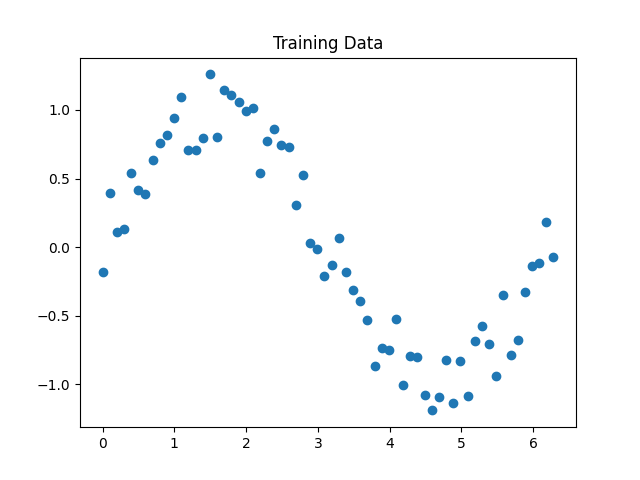

In [3]:
data_points = 64

# Let's first generate our learning target. We'll add some noise to it so that we're
# modeling a data set which is a bit imperfect. The y-values represent the function
# that we're trying to learn. Since we're generating this data ourselves, we know that
# it should be sinusoidal, but the neural network doesn't know that - it'll figure it
# out over the course of training.
#
x_vals = np.linspace(0, 2 * np.pi, data_points).reshape(-1, 1)  # .reshape(-1, 1) turns x_vals into a column vector.
y_vals = np.sin(x_vals) + np.random.uniform(-0.3, 0.3, x_vals.shape)

train_data_fig, train_data_ax = plt.subplots()

train_data_ax.set_title('Training Data')
train_data_ax.scatter(x_vals, y_vals)

With our target data set now defined, we are ready to train our very first neural network with PyTorch. The ideas and concepts we've developed up to this point have been leading up to this, and we've seen some of the complexity behind many of the seemingly simple calls in the proceeding code blocks. In our very first workshop, we proposed that it might be useful to extract commonly-used algorithms into a library - the proceeding code block demonstrates just how powerful and useful well-writen libraries can be. Adjusting the values in the call to the `visualize_neural_network` function (and hence `train_nn`) can be particularly illuminating in understanding how each parameter affects network training.

Completed 5000 training iterations.
Completed 10000 training iterations.
Completed 15000 training iterations.
Completed 20000 training iterations.


<IPython.core.display.Javascript object>


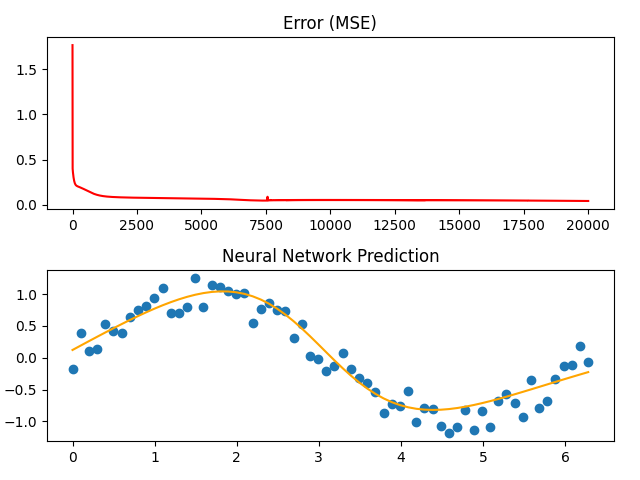

In [4]:
def train_nn(x_np, y_np, hidden_layer_size, activation_function, iterations, learning_rate=0.01, device='cpu'):   
    # w1 and b1 are the weights and biases going into the hidden layer
    # We'll initialize these to random numbers.
    #
    w1 = torch.randn(hidden_layer_size, requires_grad=True, dtype=torch.float, device=device)
    b1 = torch.randn(hidden_layer_size, requires_grad=True, dtype=torch.float, device=device)

    # w2 represents the biases applied to the output of the hidden layer.
    # We'll initialize these to random numbers.
    #
    w2 = torch.randn(hidden_layer_size, requires_grad=True, dtype=torch.float, device=device)

    optimizer = optim.SGD([w1, b1, w2], lr=learning_rate)

    # Convert numpy arrays to native tensors, which are sent to the hardware used to train the
    # neural network (GPUs are often used to speed this part up).
    #
    x = torch.from_numpy(x_np).float().to(device)
    y = torch.from_numpy(y_np).float().to(device)
    
    train_err_vals = []
    
    for i in range(0, iterations):  # Run at least once no matter what
        # Calculate predicted values for each x value, weight and bias.
        #
        y_predicted = (activation_function(x * w1 + b1) * w2).sum(1)

        # This is our standard Mean Square Error loss for training data, which we've implemented e
        # explicitly a few times by this point.
        #
        train_err = ((y_predicted - y[:,0])**2).mean()

        # This single line executes backpropagation throughout the entire network - this is
        # where libraries such as PyTorch really shine!
        #
        train_err.backward()

        # Carry out one optimization step with the provided optimizer
        #
        optimizer.step()

        # Reset gradients to zero - see this Stack Overflow question and answer for more details
        # as to why we do this: https://stackoverflow.com/a/48009142
        #
        optimizer.zero_grad()

        # We'll print a message every 1000 iterations so that we have some idea of where model
        # training is at.
        #
        if (i + 1) % 5000 == 0:
            print('Completed {} training iterations.'.format(i + 1))

        # Save error for this iteration by appending its value to the err_vals array.
        # 
        # Note that the call to .item() fetches the value from a single-valued PyTorch tensor
        # (of which this is one).
        #
        train_err_vals.append(train_err.item())

    # Get predicted values as a numpy array for plotting, analysis, etc.
    # These values represent the predictions made by our neural network.
    #
    return y_predicted.detach().cpu().numpy(), train_err_vals


def visualize_neural_network(x, y, hidden_layer_size, activation_function, iterations, learning_rate):   
    N_x, train_err_vals = train_nn(
        x,
        y,
        hidden_layer_size=hidden_layer_size,
        activation_function=activation_function,
        iterations=iterations,
        learning_rate=learning_rate,
    )
    
    # Create some plots with nice titles and layout.
    #
    fig, [err_ax, ax]= plt.subplots(2, 1)
    
    ax.set_title('Neural Network Prediction')
    err_ax.set_title('Error (MSE)')

    fig.tight_layout()
    
    # Plot training data and predictions
    #
    ax.scatter(x, y)
    ax.plot(x, N_x, color='orange')
    
    # Plot training error
    #
    err_ax.plot(np.arange(0, len(train_err_vals)), train_err_vals, color='red')
    
    return fig, ax, err_ax

nn_fig, nn_ax, nn_err_ax = visualize_neural_network(
    x_vals,
    y_vals,
    hidden_layer_size=3,
    activation_function=nn.Sigmoid(),
    iterations=20 * 1000,
    learning_rate=0.1,
)

## Can a neural network be _too_ good?

Recall that given enough training data and enough neurons in the hidden layer, neural networks are always theoretically capable of approximating the function which generated that data to an arbitrary degree of precision. Contrary to what one might initially think, more precision is not always better - because neural networks are so well-suited to matching data sets, it is easy for neural networks to incorrectly model the _actual data provided_ instead of the _phenomenon which generated the data_. When this occurs, a neural network is said to have _overfit_ the data set - this generally means that the learned model does not generalize well to similar data sets. One way to mitigate this effect is to split the available data set into _training data_ and _validation data_. From there, **only** the training data is used to learn network weights and biases, and the validation data is used as a measure of how well the network has learned to model the underlying function more so than the data set itself. Since the validation data is never used to train the network, we'd like for the validation loss to be as low as possible; a low validation loss indicates that a particular network is likely to generalize well to data sets similar to that which the model was trained on. 

This notebook's exercise is to calculate the MSE value for a validation set at each training iteration, plot that in the same view as the training loss, and use that information to decide at what point (if any) the model starts to overfit the data set. We'll generate the validation set and pass the provided $x$-values as the `x_np_validation` parameter in the `train_nn_with_validation` function below.

_Hint:_ Take a look at `train_err_vals` to see how those are calculated. Calculating the validation error (loss) values will probably be very similar!

NameError: name 'x_validation' is not defined

Completed 5000 training iterations.
Completed 10000 training iterations.
Completed 15000 training iterations.
Completed 20000 training iterations.


<IPython.core.display.Javascript object>


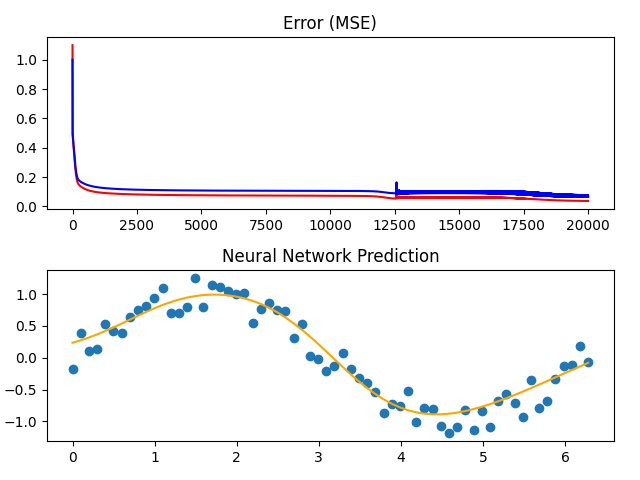

In [7]:
def train_nn_with_validation(
    x_np,
    y_np,
    x_np_validation,
    y_np_validation,
    hidden_layer_size,
    activation_function,
    iterations,
    learning_rate=0.01, device='cpu'
):   
    # Randomly initialize weights and biases
    #
    w1 = torch.randn(hidden_layer_size, requires_grad=True, dtype=torch.float, device=device)
    b1 = torch.randn(hidden_layer_size, requires_grad=True, dtype=torch.float, device=device)
    w2 = torch.randn(hidden_layer_size, requires_grad=True, dtype=torch.float, device=device)

    # Choose optimizer
    #
    optimizer = optim.SGD([w1, b1, w2], lr=learning_rate)

    # Transform numpy data sets into PyTorch data sets.
    #
    x = torch.from_numpy(x_np).float().to(device)
    y = torch.from_numpy(y_np).float().to(device)
    
    x_validation = torch.from_numpy(x_np_validation).float().to(device)
    y_validation = torch.from_numpy(y_np_validation).float().to(device)
    
    train_err_vals = []
    
    validation_err_vals = []
    
    for i in range(0, iterations):  # Run at least once no matter what
        y_predicted = (activation_function(x * w1 + b1) * w2).sum(1)
        y_validation_predictions = (activation_function(x_validation * w1 + b1) * w2).sum(1)

        train_err = ((y_predicted - y[:,0])**2).mean()
        
        validation_err = ((y_validation_predictions - y_validation[:,0])**2).mean() 

        train_err.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (i + 1) % 5000 == 0:
            print('Completed {} training iterations.'.format(i + 1))


        train_err_vals.append(train_err.item())
        
        validation_err_vals.append(validation_err.item())

    return y_predicted.detach().cpu().numpy(), train_err_vals, validation_err_vals


def visualize_neural_network_with_validation(
    x,
    y,
    x_validation_set,
    y_validation_set,
    hidden_layer_size,
    activation_function, 
    iterations,
    learning_rate
):   
    N_x, train_err_vals, validation_err_vals = train_nn_with_validation(
        x,
        y,
        x_validation_set,
        y_validation_set,
        hidden_layer_size=hidden_layer_size,
        activation_function=activation_function,
        iterations=iterations,
        learning_rate=learning_rate,
    )
    
    # Create some plots with nice titles and layout.
    #
    fig, [err_ax, ax]= plt.subplots(2, 1)
    
    ax.set_title('Neural Network Prediction')
    err_ax.set_title('Error (MSE)')

    fig.tight_layout()
    
    # Plot training data and predictions
    #
    ax.scatter(x, y)
    ax.plot(x, N_x, color='orange')
    
    # Plot training error
    #
    err_ax.plot(np.arange(0, len(train_err_vals)), train_err_vals, color='red')
    err_ax.plot(np.arange(0, len(validation_err_vals)), validation_err_vals, color='blue')
    
    return fig, ax, err_ax

# Create a set of 16 validation data points. Usually, this should be ~15% or so of your input data set.
#
x_validation_vals = np.linspace(0, 2 * np.pi, 16).reshape(-1, 1)
y_validation_vals = np.sin(x_validation_vals) + np.random.uniform(-0.4, 0.4, x_validation_vals.shape)

nn_fig, nn_ax, nn_err_ax = visualize_neural_network_with_validation(
    x_vals,
    y_vals,
    x_validation_vals,
    y_validation_vals,
    hidden_layer_size=3,
    activation_function=nn.Sigmoid(),
    iterations=20 * 1000,
    learning_rate=0.1,
)